<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/accelearting_metagenomic_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating metagenomic analysis with [Graphistry](graphistry.com)

Using GPU-accelerated UMAP + DBScan analysis & visualization, metagenomic samples can be compared faster and much more easily explored.

*   Task: Analyze metagenomic samples for similarity
*   Data: time series samples
**   563 samples collected from 84 donors, producing 4 dense long-term time series (up to 1 sample every other day during 18 months)
*   [data](https://www.ebi.ac.uk/ena/browser/view/PRJNA544527)
*   [metadata](https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-019-0559-3/MediaObjects/41591_2019_559_MOESM3_ESM.xlsx)
*   [paper](https://www-nature-com.eproxy.lib.hku.hk/articles/s41591-019-0559-3)


**Insight/ Result:**

43s to umap and dbscan vs 2342s here
over **50X** faster for a single run, and since [the reference paper for this analysis](https://journals.asm.org/doi/full/10.1128/msystems.00118-23) runs this analysis 12x per dataset (here we only have 1 dataset), we could expect to save nearly the entire 8hrs for this dataset, taking less than 10 minutes in total

(See also: [CPU baseline](https://github.com/dcolinmorgan/grph/blob/main/accelerating_chemical_mappings.ipynb))

# Setup

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11 cudf-cu11 cugraph-cu11 pylibraft_cu11 raft_dask_cu11 dask_cudf_cu11 pylibcugraph_cu11 pylibraft_cu11
import cuml,cudf
print(cuml.__version__)

!pip install -U --force git+https://github.com/graphistry/pygraphistry.git@cudf
!pip install -U git+https://github.com/graphistry/cu-cat.git@DT3
# !pip install dirty_cat

!pip install Biopython

!nvidia-smi


In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# import /configure

get a free api-key at https://www.graphistry.com/


In [3]:
import pandas as pd
import graphistry
from time import time
import cuml,cudf
print(cuml.__version__)


# graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
graphistry.__version__

23.06.00


'0.28.7+463.gfb96400'

# bio-ml dataset


1.   [3 subjects x 10 time points](
https://www.ebi.ac.uk/ena/browser/view/PRJNA544527)

2.  [metadata](
https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-019-0559-3/MediaObjects/41591_2019_559_MOESM3_ESM.xlsx)

3.   !wget https://raw.githubusercontent.com/dcolinmorgan/grph/main/ftp_PRJNA544527.txt


In [4]:
!wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR922/006/SRR9224006/SRR9224006_1.fastq.gz
!wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR922/006/SRR9224006/SRR9224006_2.fastq.gz

--2023-07-18 05:53:47--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR922/006/SRR9224006/SRR9224006_1.fastq.gz
           => ‘SRR9224006_1.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/fastq/SRR922/006/SRR9224006 ... done.
==> SIZE SRR9224006_1.fastq.gz ... 429207334
==> PASV ... done.    ==> RETR SRR9224006_1.fastq.gz ... done.
Length: 429207334 (409M) (unauthoritative)

SRR9224006_1.fastq. 100%[===================>] 409.32M  32.3MB/s    in 17s     

2023-07-18 05:54:05 (24.4 MB/s) - ‘SRR9224006_1.fastq.gz’ saved [429207334]

--2023-07-18 05:54:05--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR922/006/SRR9224006/SRR9224006_2.fastq.gz
           => ‘SRR9224006_2.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.sra.ebi.ac.uk 

In [5]:
! gunzip SRR9224006_1.fastq.gz
! gunzip SRR9224006_2.fastq.gz

In [6]:
!head /content/SRR9224006_1.fastq

@SRR9224006.1 7001174F:HVTFNBCXX161011:HVTFNBCXX:2:2206:18894:58151/1
AAAAAAAACAAAATAATGGAAACAAAAAACATCTACTTCATCAGCGGCATTGATACAGATGCCGGAAAAAGCTATTGCACCGCCTGGTATGCCCGTGAGCT
+
DDDDDIIIIIIGIIIIIIIIIIIIHIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDHGIIIIGGHIIHHHIIIIIIIHHIIIIIIHIIIIIII
@SRR9224006.2 7001174F:HVTFNBCXX161011:HVTFNBCXX:1:1108:17623:49640/1
AAAAAAAACAACCCAATGCGATTCTGATCGCAATCTACATAAGTTACTACTGGTTATCTTCCCTGAAG
+
DDBDDIGIIHIIIGHGHFHIGHIIIEHIHIIIIIIIIIIIIEHHHGHIIIIIIIIIIIIIIEHHHHHH
@SRR9224006.3 7001174F:HVTFNBCXX161011:HVTFNBCXX:1:1204:5345:82516/1
AAAAAAAACAAGAGCTTTATTAAACACGTCTTGATCTTTTTTACACCTGCCGGAAATTCCATCGT


In [7]:
from Bio import SeqIO
import glob,os
import pandas as pd
B=pd.DataFrame()
for i in glob.glob('/content/*.fastq'):
    # j=os.path.basename(i)
    fasta_sequences = SeqIO.parse(open(i),'fastq')
    identifiers = []
    sequences = []
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        identifiers.append(name)
        sequences.append(sequence)

    A=pd.DataFrame([identifiers,sequences]).T
    A.columns=['ID','seq']
    A.dropna(inplace=True)
    B=B.append(A)
    # A['ID']#=A.ID.str.split('-')[0:1]
# B['ID']=B['ID'].str.split('-').str[0]+'_'+B['ID'].str.split('-').str[1]#.cat()
B['ID']=B.ID.str.split('_length').str[0]
B.index=B.ID

<ipython-input-7-457fd4362762>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B=B.append(A)
<ipython-input-7-457fd4362762>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B=B.append(A)


# install [HUMAnN 3](https://huttenhower.sph.harvard.edu/humann), a method for efficiently and accurately profiling the abundance of microbial metabolic pathways and other molecular functions from metagenomic or metatranscriptomic sequencing data.

In [ ]:
# !pip install humann --no-binary :all:
!pip install metaphlan

In [9]:
### !humann_databases --download utility_mapping full /path/to/databases --update-config yes

# !humann_test

# !wget https://github.com/biobakery/humann/raw/master/examples/demo.fastq.gz
# !humann -i demo.fastq.gz -o sample_results

### takes very long for running all samples
 (1day+ run on cluster)

In [11]:
# mkdir assemble epi_sam_out mpa4_out
# # !humann -i /content/All_MAGs/Sample_101_S75_bin_1.fa -o test_out
# %%bash
# seq=$(ls /content/*.fastq | cut -d / -f2| cut -d _ -f1)

# for i in $(eval "echo "$seq" | cut -d _ -f1")

# do
# metaphlan /content/${i}.fa --nproc 40 --input_type fasta -o /content/assemble/${i}/h4_out.txt -t rel_ab_w_read_stats
# done

# umap and dbscan

idea for metagenomic analysis based on [Quantifying Shared and Unique Gene Content across 17 Microbial Ecosystems
](https://journals.asm.org/doi/full/10.1128/msystems.00118-23)

(analyze all samples run on cluster)

In [ ]:
# from sqlalchemy.util.compat import dataclass_fields
!wget https://github.com/dcolinmorgan/grph/raw/main/PRJNA544527_mpa4out.txt
data=pd.read_csv('/content/PRJNA544527_mpa4out.txt',sep='\t',skiprows=1,index_col=0)
data.index=data.reset_index().clade_name.str.split('|',expand=True)[6]
data=data.reset_index().dropna(axis=0)
data.index=data[6]
data=data.drop(columns=6)

!wget https://raw.githubusercontent.com/dcolinmorgan/grph/main/PRJNA544527-meta_inf.txt
meta=pd.read_csv('/content/PRJNA544527-meta_inf.txt',sep='\t',header=None)

mm=pd.merge(data.T,meta[[3,5]],left_index=True,right_on=3)

mm['id']=mm[5].str.split('-').str[0]
mm['time']=mm[5].str.split('_').str[0].str.split('-').str[1]

!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-019-0559-3/MediaObjects/41591_2019_559_MOESM3_ESM.xlsx
metaa=pd.read_excel('/content/41591_2019_559_MOESM3_ESM.xlsx',sheet_name='SupTable2',skiprows=3)
metaa=metaa[['Donor','Age','Sex','BMI']]

Full_table=pd.merge(mm,metaa,left_on='id',right_on='Donor')
Full_table=Full_table.drop(columns=[3,	5,	'id'])
# Full_table.time=pd.to_datetime(Full_table.time,unit='d')
# Full_table.time=Full_table.time.values.astype('datetime64[M]')

data2=Full_table.melt(id_vars=['time','Donor','Age','Sex','BMI'])
# data2.to_csv('PRJNA544527_mpa4_annot_table.txt',sep='\t')

data2=data2.rename(columns={'variable':'species'})
data2=data2.sort_values(by=['Donor','time','value'])
# final df stored here also
# !wget https://raw.githubusercontent.com/dcolinmorgan/grph/main/PRJNA544527_mpa4_annot_table.txt
# data2=pd.read_csv('PRJNA544527_mpa4_annot_table.txt',sep='\t',index_col=0)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/PRJNA544527_mpa4_annot_table.txt /content/drive/MyDrive/graphistry/metagen_demo/

In [14]:
g = graphistry.nodes(cudf.from_pandas(data2[['variable','value']]))

t=time()
g2=g.featurize(feature_engine='cu_cat',memoize=False)
g3=g2.umap(dbscan=True,engine='cuml')
print("\n"+str(time()-t))

emb2=g3._node_embedding
emb2['time']=data2.time
emb2['_n']=data2.variable
emb2['index']=data2.variable
g22=graphistry.nodes(emb2.reset_index(),'index').edges(g3._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
##440s

Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat


Using GPU: cu_cat



433.21663880348206


In [ ]:
g22.plot()

[per the Materials and Methods of our inspirational paper,](https://journals.asm.org/doi/full/10.1128/msystems.00118-23#sec-4)from these (too) many clusters, one can perform cluster-based functional enrichment analysis, cluster-based taxonomoical enrichment analysis and/or identify of ecologically conserved genes and differentially abundant genes

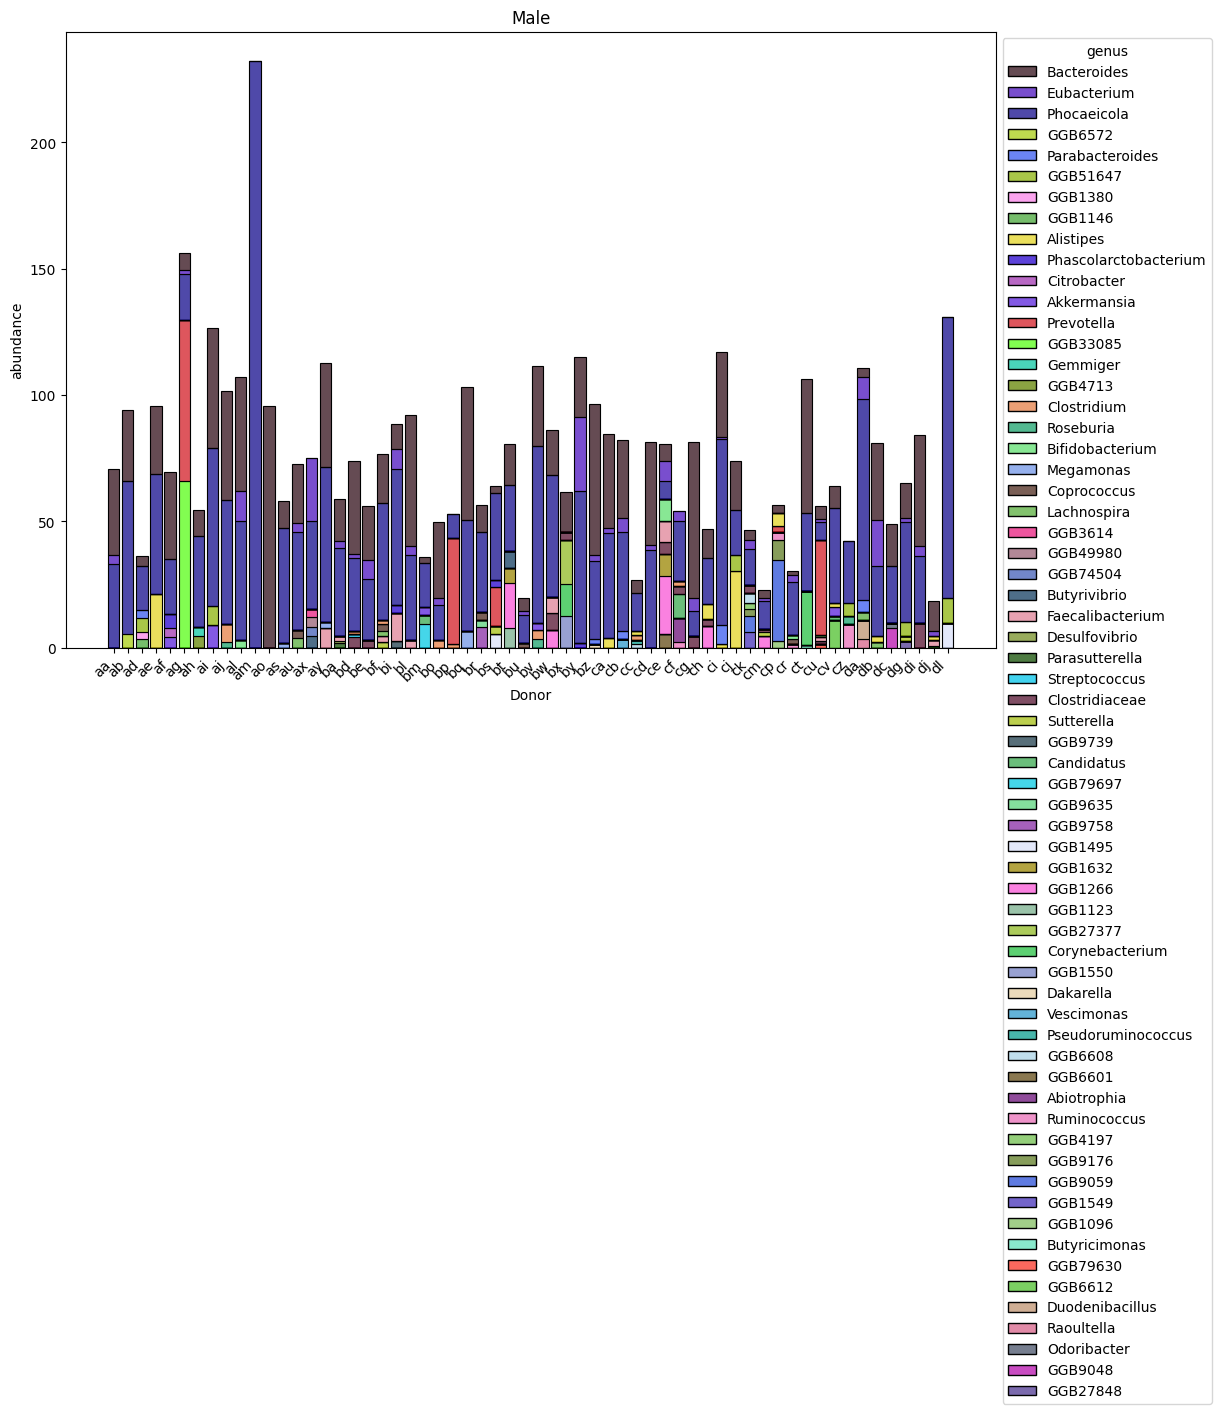

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
data2['genus']=data2['species'].str.split('_').str[2]

chars = '0123456789ABCDEF'
palette_colors=['#'+''.join(random.sample(chars,6)) for i in range(len(pd.unique(data2.genus)))]
palette_dict = {genus: color for genus, color in zip(pd.unique(data2.genus), palette_colors)}



plt.figure(figsize=(12,8))
ax = sns.histplot(data2[data2['Sex']=='Male'], x='Donor', hue='genus', weights='value',
             multiple='stack', palette=palette_dict, shrink=0.8)
ax.set_ylabel('abundance')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Male')

legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))


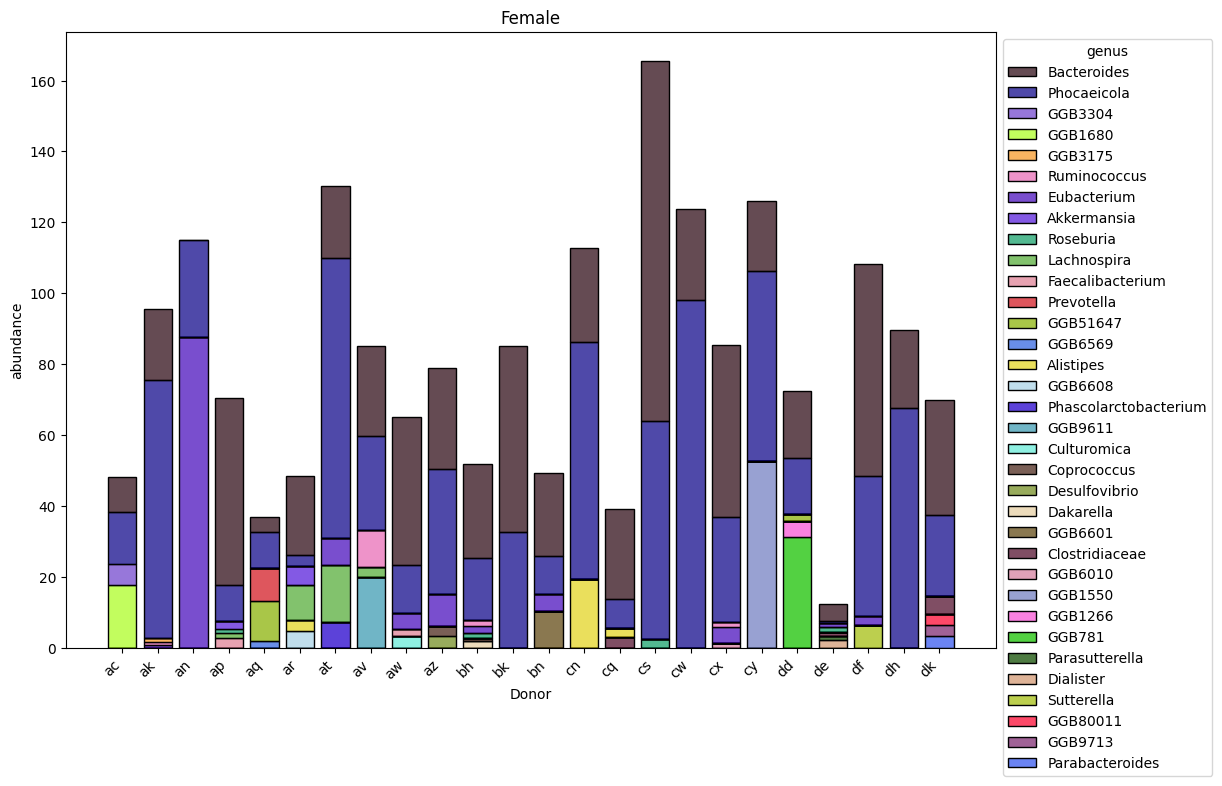

In [30]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data2[data2['Sex']=='Female'], x='Donor', hue='genus', weights='value',
             multiple='stack', palette=palette_dict, shrink=0.8)
ax.set_ylabel('abundance')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Female')

legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))


In [20]:
data2=data2[data2.value>0]
data2=data2.reset_index(drop = True)
data2=data2.drop_duplicates()

data2["Label"] = (
    data2.groupby("Donor")
    .apply(lambda x: x.groupby("time", sort=False).ngroup() + 1)
    .values
)

cc=pd.unique(data2[data2.Label<5].Donor)
data2=data2.loc[ data2.Donor.isin(cc), : ]
data2=data2[data2.Label<5]

data2["rank"] = data2.groupby("Donor")["value"].rank(method="dense", ascending=False)
data2=data2[data2['rank']<10.0]


grouped = data2.groupby('Donor')
def get_next_clus(x): return x['species'].shift(-1)
data2["next_species"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)
grouped = data2.groupby('Donor')

  # Working on the «nodes_dict
import random
data2_spec = list(data2.species.unique())
chars = '0123456789ABCDEF'
palette=[''+''.join(random.sample(chars,6)) for i in range(len(data2_spec))]
output = dict()
output.update({'nodes_dict': dict()})
i = 0
for Label in data2.Label.unique():
    output['nodes_dict'].update(
        {Label: dict()}
    )

    data2_spec_at_this_Label = data2[data2['Label'] ==
                                   Label]['species'].unique()

    Label_palette = []
    for spec in data2_spec_at_this_Label:
        Label_palette.append(palette[list(data2_spec).index(spec)])

    output['nodes_dict'][Label].update(
        {
            'sources': list(data2_spec_at_this_Label),
            'color': Label_palette,
            'sources_index': list(range(i, i+len(data2_spec_at_this_Label)))
        }
    )
    i += len(output['nodes_dict'][Label]['sources_index'])


  # Working on the links_dict
import random
output.update({'links_dict': dict()})
grouped = data2.groupby(['Donor', 'Label'])

def update_source_target(user):
    try:

        source_index = output['nodes_dict'][user.name[1]]['sources_index'][output['nodes_dict']
                                                                           [user.name[1]]['sources'].index(user['species'].values[0])]

        target_index = output['nodes_dict'][user.name[1] + 1]['sources_index'][output['nodes_dict']
                                                                               [user.name[1] + 1]['sources'].index(user['next_species'].values[0])]

         # If this source is already in links_dict...
        if source_index in output['links_dict']:
            # ...and if this target is already associated to this source...
            if target_index in output['links_dict'][source_index]:
                # ...then we increment the count of users with this source/target pair by 1
                output['links_dict'][source_index][target_index]['value'] += 1
            # ...but if the target is not already associated to this source...
            else:
                # ...we create a new key for this target, for this source, and initiate it with 1 user and the time from source to target
                output['links_dict'][source_index].update({target_index:
                                                           dict(
                                                               {'value': 1}
                                                            )
                                                           })
        # ...but if this source isn't already available in the links_dict, we create its key and the key of this source's target, and we initiate it with 1 user and the time from source to target
        else:
            output['links_dict'].update({source_index: dict({target_index: dict(
                {'value': 1})})})
    except Exception as e:
        pass

grouped.apply(lambda user: update_source_target(user))

""


In [21]:
targets = []
sources = []
values = []

for source_key, source_value in output['links_dict'].items():
    for target_key, target_value in output['links_dict'][source_key].items():
        sources.append(source_key)
        targets.append(target_key)
        values.append(target_value['value'])

labels = []
colors = []

for key, value in output['nodes_dict'].items():
    labels = labels + list(output['nodes_dict'][key]['sources'])
    colors = colors + list(output['nodes_dict'][key]['color'])
for idx, color in enumerate(colors):
    colors[idx] = "#" + str(color) + ""

In [23]:
import plotly.graph_objects as go
import plotly.express as px
import seaborn as se
import matplotlib.pyplot as plt
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=20,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        hovertemplate='%{value} unique species episodes went from %{source.label} to %{target.label}.',
    ))])

fig.update_layout(autosize=True, title=dict(text="Movement of Top 10 Species During Time Series", font_size=16), font=dict(size=12, family="Arial"), plot_bgcolor='white')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)

In [ ]:
import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='dcolinmorgan', api_key='***')
py.iplot(fig, sharing='public', filename='Meta-time-sankey')